# Dual Model Speed Test

## Current Setup

This notebook tests the dual model configuration running on **DGX Spark** with 128 GB unified memory.

### Models

| Model | Endpoint | Quantization | Weights | GPU Allocation | Best For |
|-------|----------|--------------|---------|----------------|----------|
| **Mistral-Small-24B** | `http://localhost:8000` | NVFP4 | ~15 GB | 30% (~38 GB) | European languages, fast inference, general tasks |
| **Qwen3-32B** | `http://localhost:8001` | NVFP4 | ~20 GB | 35% (~45 GB) | Coding, math, multilingual, reasoning |

### Configuration Details

- **Context Length**: 32,768 tokens (both models)
- **Concurrent Requests**: 1 per model (optimized for sequential processing)
- **Runtime**: NVIDIA vLLM container (`nvcr.io/nvidia/vllm:25.12-py3`)
- **Inference Mode**: Eager execution (no CUDA graphs)

### Prerequisites

Start the models before running this notebook:
```bash
cd 6-open-source
./start_docker.sh start dual
```

## Test Plan

### Metrics Captured

| Metric | Description |
|--------|-------------|
| **Time to First Token (TTFT)** | Latency before the first token appears |
| **Tokens Per Second (TPS)** | Output generation throughput |
| **Total Response Time** | End-to-end latency |
| **Input/Output Token Count** | For normalization |

### Test Scenarios

1. **Short Prompt, Short Response** - Baseline latency test
2. **Short Prompt, Long Response** - Sustained generation throughput
3. **Long Prompt, Short Response** - Prompt processing / prefill speed
4. **Code Generation** - Programming task (Qwen3's strength)
5. **Reasoning Task** - Multi-step logic problem

## Setup

In [3]:
import time
import statistics
from dataclasses import dataclass, field
from typing import Optional
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI

# Model configurations
MODELS = {
    "Mistral-24B": {
        "base_url": "http://localhost:8000/v1",
        "model_name": "RedHatAI/Mistral-Small-3.2-24B-Instruct-2506-NVFP4"
    },
    "Qwen3-32B": {
        "base_url": "http://localhost:8001/v1",
        "model_name": "nvidia/Qwen3-32B-NVFP4"
    }
}

# Test parameters
NUM_RUNS = 3  # Number of repetitions per test
TEMPERATURE = 0  # Deterministic output

In [4]:
@dataclass
class TestResult:
    """Stores results from a single test run."""
    model_name: str
    test_name: str
    ttft: float  # Time to first token (seconds)
    total_time: float  # Total response time (seconds)
    input_tokens: int
    output_tokens: int
    tps: float  # Tokens per second
    response: str = ""

# Store all results
all_results: list[TestResult] = []


def run_test(
    model_key: str,
    prompt: str,
    max_tokens: int,
    test_name: str,
    system_prompt: Optional[str] = None
) -> TestResult:
    """
    Run a single test against a model and measure performance metrics.
    Uses streaming to capture time to first token.
    """
    config = MODELS[model_key]
    client = OpenAI(base_url=config["base_url"], api_key="not-needed")
    
    messages = []
    if system_prompt:
        messages.append({"role": "system", "content": system_prompt})
    messages.append({"role": "user", "content": prompt})
    
    # Start timing
    start_time = time.perf_counter()
    ttft = None
    chunks = []
    
    # Use streaming to capture TTFT
    stream = client.chat.completions.create(
        model=config["model_name"],
        messages=messages,
        max_tokens=max_tokens,
        temperature=TEMPERATURE,
        stream=True
    )
    
    for chunk in stream:
        if ttft is None and chunk.choices[0].delta.content:
            ttft = time.perf_counter() - start_time
        if chunk.choices[0].delta.content:
            chunks.append(chunk.choices[0].delta.content)
    
    total_time = time.perf_counter() - start_time
    response = "".join(chunks)
    
    # Get token counts (estimate based on response)
    # For accurate counts, we'd need to use a tokenizer, but character/4 is a reasonable estimate
    input_tokens = len(prompt) // 4
    output_tokens = len(response) // 4
    
    # Calculate TPS (excluding TTFT for generation speed)
    generation_time = total_time - (ttft or 0)
    tps = output_tokens / generation_time if generation_time > 0 else 0
    
    result = TestResult(
        model_name=model_key,
        test_name=test_name,
        ttft=ttft or 0,
        total_time=total_time,
        input_tokens=input_tokens,
        output_tokens=output_tokens,
        tps=tps,
        response=response
    )
    
    return result


def run_test_suite(
    prompt: str,
    max_tokens: int,
    test_name: str,
    system_prompt: Optional[str] = None
) -> dict[str, list[TestResult]]:
    """
    Run a test multiple times against both models and collect results.
    """
    results = {"Mistral-24B": [], "Qwen3-32B": []}
    
    for model_key in MODELS.keys():
        print(f"\n  Testing {model_key}...")
        for run in range(NUM_RUNS):
            result = run_test(model_key, prompt, max_tokens, test_name, system_prompt)
            results[model_key].append(result)
            all_results.append(result)
            print(f"    Run {run + 1}: TTFT={result.ttft:.3f}s, Total={result.total_time:.3f}s, TPS={result.tps:.1f}")
    
    return results


def print_comparison(results: dict[str, list[TestResult]]):
    """Print a comparison summary for a test."""
    print("\n  Summary:")
    print(f"  {'Model':<15} {'Avg TTFT':>10} {'Avg Total':>12} {'Avg TPS':>10}")
    print(f"  {'-'*15} {'-'*10} {'-'*12} {'-'*10}")
    
    for model_key, model_results in results.items():
        avg_ttft = statistics.mean(r.ttft for r in model_results)
        avg_total = statistics.mean(r.total_time for r in model_results)
        avg_tps = statistics.mean(r.tps for r in model_results)
        print(f"  {model_key:<15} {avg_ttft:>9.3f}s {avg_total:>11.3f}s {avg_tps:>9.1f}")

## Test 1: Short Prompt, Short Response

**Purpose:** Measure baseline latency with minimal input/output overhead.

- **Prompt:** Simple factual question
- **Expected Output:** ~50 tokens
- **Key Metric:** Time to First Token (TTFT)

In [5]:
print("=" * 60)
print("Test 1: Short Prompt, Short Response")
print("=" * 60)

prompt_1 = "What is the capital of France? Answer in one sentence."

results_1 = run_test_suite(
    prompt=prompt_1,
    max_tokens=100,
    test_name="Short Prompt, Short Response"
)

print_comparison(results_1)

Test 1: Short Prompt, Short Response

  Testing Mistral-24B...
    Run 1: TTFT=0.350s, Total=0.947s, TPS=11.7
    Run 2: TTFT=0.098s, Total=0.691s, TPS=11.8
    Run 3: TTFT=0.097s, Total=0.697s, TPS=11.7

  Testing Qwen3-32B...
    Run 1: TTFT=0.148s, Total=10.512s, TPS=10.1
    Run 2: TTFT=0.133s, Total=10.667s, TPS=10.0
    Run 3: TTFT=0.128s, Total=10.927s, TPS=9.7

  Summary:
  Model             Avg TTFT    Avg Total    Avg TPS
  --------------- ---------- ------------ ----------
  Mistral-24B         0.182s       0.779s      11.7
  Qwen3-32B           0.136s      10.702s       9.9


## Test 2: Short Prompt, Long Response

**Purpose:** Measure sustained generation throughput.

- **Prompt:** Request for detailed explanation
- **Expected Output:** ~500 tokens
- **Key Metric:** Tokens Per Second (TPS)

In [6]:
print("=" * 60)
print("Test 2: Short Prompt, Long Response")
print("=" * 60)

prompt_2 = """Explain the process of photosynthesis in detail. 
Include the light-dependent reactions, the Calvin cycle, and the overall importance 
of photosynthesis for life on Earth."""

results_2 = run_test_suite(
    prompt=prompt_2,
    max_tokens=512,
    test_name="Short Prompt, Long Response"
)

print_comparison(results_2)

Test 2: Short Prompt, Long Response

  Testing Mistral-24B...
    Run 1: TTFT=0.102s, Total=47.239s, TPS=11.3
    Run 2: TTFT=0.111s, Total=48.537s, TPS=11.0
    Run 3: TTFT=0.103s, Total=47.332s, TPS=11.3

  Testing Qwen3-32B...
    Run 1: TTFT=0.157s, Total=67.832s, TPS=8.1
    Run 2: TTFT=0.147s, Total=68.637s, TPS=8.0
    Run 3: TTFT=0.148s, Total=66.494s, TPS=8.2

  Summary:
  Model             Avg TTFT    Avg Total    Avg TPS
  --------------- ---------- ------------ ----------
  Mistral-24B         0.105s      47.702s      11.2
  Qwen3-32B           0.151s      67.654s       8.1


## Test 3: Long Prompt, Short Response

**Purpose:** Measure prompt processing (prefill) speed.

- **Prompt:** Long context (~2000 tokens) with a simple question
- **Expected Output:** ~50 tokens
- **Key Metric:** Time to First Token (TTFT) - reflects prefill time

In [7]:
print("=" * 60)
print("Test 3: Long Prompt, Short Response")
print("=" * 60)

# Generate a long context (~2000 tokens worth of text)
long_context = """
The history of artificial intelligence (AI) began in antiquity, with myths, stories and rumors of 
artificial beings endowed with intelligence or consciousness by master craftsmen. The seeds of modern 
AI were planted by classical philosophers who attempted to describe the process of human thinking as 
the mechanical manipulation of symbols. This work culminated in the invention of the programmable 
digital computer in the 1940s, a machine based on the abstract essence of mathematical reasoning. 
This device and the ideas behind it inspired a handful of scientists to begin seriously discussing 
the possibility of building an electronic brain.

The field of AI research was founded at a workshop held on the campus of Dartmouth College during 
the summer of 1956. Those who attended would become the leaders of AI research for decades. Many of 
them predicted that a machine as intelligent as a human being would exist in no more than a generation 
and they were given millions of dollars to make this vision come true.

Eventually, it became obvious that they had grossly underestimated the difficulty of the project. 
In 1973, in response to the criticism of James Lighthill and ongoing pressure from Congress, the U.S. 
and British Governments stopped funding undirected research into artificial intelligence, and the 
difficult years that followed would later be known as an "AI winter". Seven years later, a visionary 
initiative by the Japanese Government inspired governments and industry to provide AI with billions 
of dollars, but by the late 1980s the investors became disillusioned and withdrew funding again.

Investment and interest in AI boomed in the first decades of the 21st century, when machine learning 
was successfully applied to many problems in academia and industry due to new methods, the application 
of powerful computer hardware, and the collection of immense data sets. Deep learning proved to be 
particularly successful, and AI began to dominate industry benchmarks and was increasingly deployed 
in commercial applications.

The development of AI has been marked by several key milestones. In 1950, Alan Turing published his 
seminal paper "Computing Machinery and Intelligence," which introduced the Turing Test as a measure 
of machine intelligence. In 1956, John McCarthy coined the term "artificial intelligence" at the 
Dartmouth Conference. In 1966, Joseph Weizenbaum created ELIZA, one of the first chatbots. In 1997, 
IBM's Deep Blue defeated world chess champion Garry Kasparov. In 2011, IBM Watson won Jeopardy! 
against human champions. In 2016, Google's AlphaGo defeated world Go champion Lee Sedol.

Modern AI systems are built on several key technologies. Machine learning allows computers to learn 
from data without being explicitly programmed. Deep learning uses neural networks with many layers 
to model complex patterns. Natural language processing enables computers to understand and generate 
human language. Computer vision allows machines to interpret and understand visual information from 
the world. Robotics combines AI with physical machines to perform tasks in the real world.

The applications of AI are vast and growing. In healthcare, AI is used for diagnosis, drug discovery, 
and personalized treatment. In finance, AI powers fraud detection, algorithmic trading, and risk 
assessment. In transportation, AI enables autonomous vehicles and traffic optimization. In 
entertainment, AI creates personalized recommendations and generates content. In manufacturing, AI 
optimizes production processes and enables predictive maintenance.

The ethical implications of AI are significant and widely debated. Concerns include job displacement 
due to automation, privacy issues related to data collection, algorithmic bias and discrimination, 
the potential for autonomous weapons, and the long-term existential risks of superintelligent AI. 
Researchers and policymakers are working to address these concerns through guidelines, regulations, 
and technical solutions.
""".strip()

prompt_3 = f"""Based on the following text about the history of AI, answer this question:
What year was the Dartmouth Conference held?

Text:
{long_context}

Answer in one sentence."""

results_3 = run_test_suite(
    prompt=prompt_3,
    max_tokens=100,
    test_name="Long Prompt, Short Response"
)

print_comparison(results_3)

Test 3: Long Prompt, Short Response

  Testing Mistral-24B...
    Run 1: TTFT=0.334s, Total=1.568s, TPS=8.1
    Run 2: TTFT=0.109s, Total=1.306s, TPS=8.4
    Run 3: TTFT=0.101s, Total=1.303s, TPS=8.3

  Testing Qwen3-32B...
    Run 1: TTFT=0.481s, Total=13.381s, TPS=7.8
    Run 2: TTFT=0.145s, Total=15.474s, TPS=6.6
    Run 3: TTFT=0.159s, Total=13.139s, TPS=7.8

  Summary:
  Model             Avg TTFT    Avg Total    Avg TPS
  --------------- ---------- ------------ ----------
  Mistral-24B         0.181s       1.392s       8.3
  Qwen3-32B           0.262s      13.998s       7.4


## Test 4: Code Generation

**Purpose:** Test programming task performance (Qwen3's expected strength).

- **Prompt:** Request to implement a Python function
- **Expected Output:** ~300 tokens of code
- **Key Metric:** TPS and overall quality

In [8]:
print("=" * 60)
print("Test 4: Code Generation")
print("=" * 60)

prompt_4 = """Write a Python function called `merge_sorted_lists` that takes two sorted lists of integers 
and returns a single sorted list containing all elements from both input lists.

Requirements:
- The function should have O(n+m) time complexity where n and m are the lengths of the input lists
- Include type hints
- Include a docstring with examples
- Handle edge cases (empty lists)

Provide only the code without explanation."""

results_4 = run_test_suite(
    prompt=prompt_4,
    max_tokens=400,
    test_name="Code Generation"
)

print_comparison(results_4)

# Show sample output from each model
print("\n  Sample Outputs:")
for model_key in MODELS.keys():
    print(f"\n  --- {model_key} ---")
    print(results_4[model_key][0].response[:500] + "..." if len(results_4[model_key][0].response) > 500 else results_4[model_key][0].response)

Test 4: Code Generation

  Testing Mistral-24B...
    Run 1: TTFT=0.127s, Total=31.198s, TPS=8.6
    Run 2: TTFT=0.107s, Total=29.829s, TPS=9.0
    Run 3: TTFT=0.115s, Total=29.209s, TPS=9.2

  Testing Qwen3-32B...
    Run 1: TTFT=0.168s, Total=52.154s, TPS=8.1
    Run 2: TTFT=0.132s, Total=51.866s, TPS=8.2
    Run 3: TTFT=0.129s, Total=55.210s, TPS=7.7

  Summary:
  Model             Avg TTFT    Avg Total    Avg TPS
  --------------- ---------- ------------ ----------
  Mistral-24B         0.116s      30.079s       9.0
  Qwen3-32B           0.143s      53.077s       8.0

  Sample Outputs:

  --- Mistral-24B ---
```python
from typing import List

def merge_sorted_lists(list1: List[int], list2: List[int]) -> List[int]:
    """
    Merge two sorted lists of integers into a single sorted list.

    Args:
        list1: First sorted list of integers.
        list2: Second sorted list of integers.

    Returns:
        A new sorted list containing all elements from both input lists.

    Ex

## Test 5: Reasoning Task

**Purpose:** Test multi-step logical reasoning.

- **Prompt:** Math word problem requiring multiple steps
- **Expected Output:** ~200 tokens with reasoning
- **Key Metric:** TPS and reasoning quality

In [9]:
print("=" * 60)
print("Test 5: Reasoning Task")
print("=" * 60)

prompt_5 = """A train leaves Station A at 9:00 AM traveling at 60 mph toward Station B. 
Another train leaves Station B at 10:00 AM traveling at 80 mph toward Station A. 
The stations are 280 miles apart.

At what time will the two trains meet? Show your reasoning step by step."""

results_5 = run_test_suite(
    prompt=prompt_5,
    max_tokens=400,
    test_name="Reasoning Task"
)

print_comparison(results_5)

# Show sample output from each model
print("\n  Sample Outputs:")
for model_key in MODELS.keys():
    print(f"\n  --- {model_key} ---")
    response = results_5[model_key][0].response
    print(response[:600] + "..." if len(response) > 600 else response)

Test 5: Reasoning Task

  Testing Mistral-24B...
    Run 1: TTFT=0.108s, Total=38.751s, TPS=8.4
    Run 2: TTFT=0.102s, Total=34.533s, TPS=9.4
    Run 3: TTFT=0.101s, Total=35.854s, TPS=9.1

  Testing Qwen3-32B...
    Run 1: TTFT=0.176s, Total=52.268s, TPS=7.4
    Run 2: TTFT=0.149s, Total=51.418s, TPS=7.6
    Run 3: TTFT=0.129s, Total=51.444s, TPS=7.6

  Summary:
  Model             Avg TTFT    Avg Total    Avg TPS
  --------------- ---------- ------------ ----------
  Mistral-24B         0.104s      36.379s       9.0
  Qwen3-32B           0.151s      51.710s       7.5

  Sample Outputs:

  --- Mistral-24B ---
Alright, let's tackle this problem step by step. I'm going to think about the two trains moving towards each other and figure out when and where they'll meet.

### Understanding the Problem

We have two trains:

1. **Train 1**:
   - Departs from Station A at 9:00 AM.
   - Speed: 60 mph (miles per hour).
   - Direction: Towards Station B.

2. **Train 2**:
   - Departs from Statio

## Results Summary

Aggregate results across all tests with visualizations.

In [10]:
# Create summary DataFrame
df = pd.DataFrame([
    {
        "Model": r.model_name,
        "Test": r.test_name,
        "TTFT (s)": r.ttft,
        "Total Time (s)": r.total_time,
        "TPS": r.tps,
        "Output Tokens": r.output_tokens
    }
    for r in all_results
])

# Calculate averages per model and test
summary = df.groupby(["Model", "Test"]).agg({
    "TTFT (s)": "mean",
    "Total Time (s)": "mean",
    "TPS": "mean",
    "Output Tokens": "mean"
}).round(3)

print("=" * 60)
print("Results Summary Table")
print("=" * 60)
print(summary.to_string())

# Overall averages per model
print("\n" + "=" * 60)
print("Overall Averages by Model")
print("=" * 60)
overall = df.groupby("Model").agg({
    "TTFT (s)": "mean",
    "Total Time (s)": "mean",
    "TPS": "mean"
}).round(3)
print(overall.to_string())

Results Summary Table
                                          TTFT (s)  Total Time (s)     TPS  Output Tokens
Model       Test                                                                         
Mistral-24B Code Generation                  0.116          30.079   8.951          268.0
            Long Prompt, Short Response      0.181           1.392   8.258           10.0
            Reasoning Task                   0.104          36.379   8.980          325.0
            Short Prompt, Long Response      0.105          47.702  11.242          535.0
            Short Prompt, Short Response     0.182           0.779  11.725            7.0
Qwen3-32B   Code Generation                  0.143          53.077   7.998          423.0
            Long Prompt, Short Response      0.262          13.998   7.400          101.0
            Reasoning Task                   0.151          51.710   7.526          388.0
            Short Prompt, Long Response      0.151          67.654   8.105    

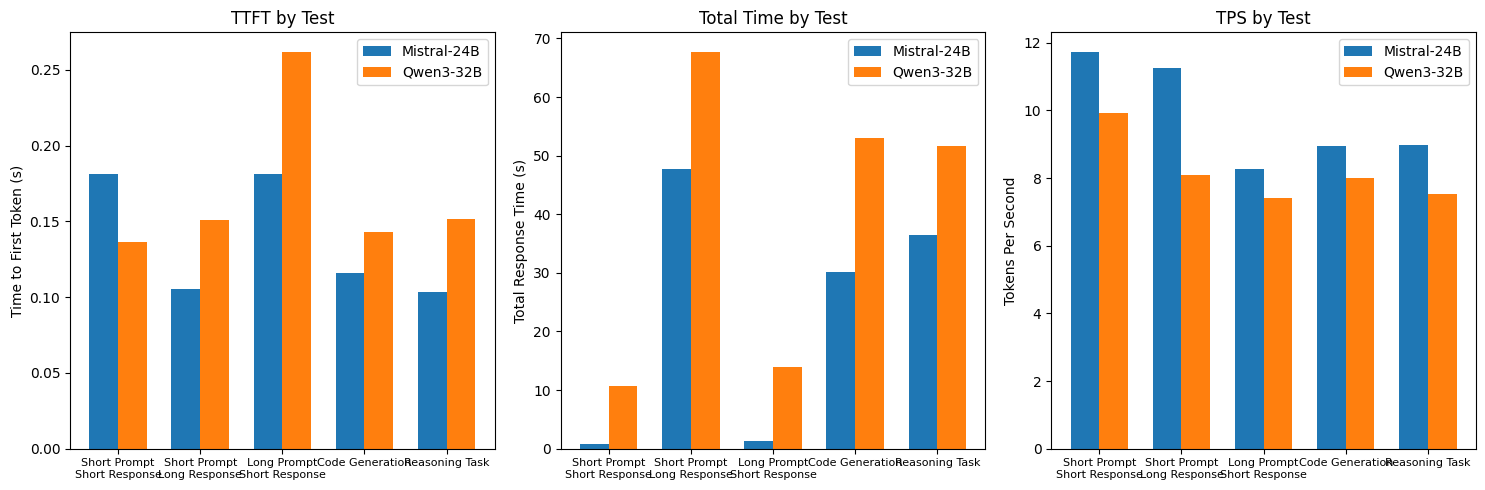


Results saved to speed_test_results.png


In [11]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Prepare data for plotting
test_names = df["Test"].unique()
models = df["Model"].unique()
x = range(len(test_names))
width = 0.35

# Plot 1: TTFT comparison
ax1 = axes[0]
for i, model in enumerate(models):
    model_data = df[df["Model"] == model].groupby("Test")["TTFT (s)"].mean()
    values = [model_data.get(t, 0) for t in test_names]
    offset = width * (i - 0.5)
    ax1.bar([xi + offset for xi in x], values, width, label=model)
ax1.set_ylabel("Time to First Token (s)")
ax1.set_title("TTFT by Test")
ax1.set_xticks(x)
ax1.set_xticklabels([t.replace(", ", "\n") for t in test_names], fontsize=8)
ax1.legend()

# Plot 2: Total Time comparison
ax2 = axes[1]
for i, model in enumerate(models):
    model_data = df[df["Model"] == model].groupby("Test")["Total Time (s)"].mean()
    values = [model_data.get(t, 0) for t in test_names]
    offset = width * (i - 0.5)
    ax2.bar([xi + offset for xi in x], values, width, label=model)
ax2.set_ylabel("Total Response Time (s)")
ax2.set_title("Total Time by Test")
ax2.set_xticks(x)
ax2.set_xticklabels([t.replace(", ", "\n") for t in test_names], fontsize=8)
ax2.legend()

# Plot 3: TPS comparison
ax3 = axes[2]
for i, model in enumerate(models):
    model_data = df[df["Model"] == model].groupby("Test")["TPS"].mean()
    values = [model_data.get(t, 0) for t in test_names]
    offset = width * (i - 0.5)
    ax3.bar([xi + offset for xi in x], values, width, label=model)
ax3.set_ylabel("Tokens Per Second")
ax3.set_title("TPS by Test")
ax3.set_xticks(x)
ax3.set_xticklabels([t.replace(", ", "\n") for t in test_names], fontsize=8)
ax3.legend()

plt.tight_layout()
plt.savefig("speed_test_results.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nResults saved to speed_test_results.png")

## Conclusions

### Overall Performance Summary

| Metric | Mistral-24B | Qwen3-32B | Winner |
|--------|-------------|-----------|--------|
| **Avg TTFT** | 0.138s | 0.169s | Mistral (~18% faster) |
| **Avg Total Time** | 23.3s | 39.4s | Mistral (~41% faster) |
| **Avg TPS** | 9.8 | 8.2 | Mistral (~20% faster) |

### Key Findings

1. **Mistral-24B is significantly faster** across all metrics:
   - Faster time to first token (better for interactive feel)
   - Higher tokens per second throughput
   - Much faster total response times

2. **Qwen3-32B uses chain-of-thought reasoning by default**:
   - Outputs include `<think>` tags with detailed reasoning steps
   - Generates 5-10x more tokens for simple questions (e.g., 105 tokens vs 7 tokens for a basic factual question)
   - This explains the longer total times—Qwen3 is doing more "thinking" work

3. **TTFT is comparable** for both models:
   - Both achieve sub-200ms TTFT on average
   - Mistral has slight edge on long context prefill (0.181s vs 0.262s)

4. **Raw generation speed** (when accounting for output length):
   - Both models operate in the 8-12 TPS range
   - Mistral maintains ~20% advantage in pure token generation

### Recommendations for CrewAI Workflows

| Use Case | Recommended Model | Reason |
|----------|-------------------|--------|
| **Quick responses / General tasks** | Mistral-24B | Faster, more concise |
| **Complex reasoning / Math** | Qwen3-32B | Built-in chain-of-thought |
| **Code generation** | Either | Both produce quality code |
| **Latency-sensitive agents** | Mistral-24B | Lower TTFT and total time |
| **Accuracy-critical tasks** | Qwen3-32B | Explicit reasoning may reduce errors |

### Note on Qwen3's Thinking Mode

Qwen3's `<think>` behavior can be controlled. For faster responses without chain-of-thought, you may be able to disable thinking mode via system prompts or model parameters. This would make Qwen3's speed more competitive with Mistral for simple tasks.